In [1]:
drive_path = '/Volumes/Brain2016'
import numpy as np
import pandas as pd
import os
import sys
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import seaborn

manifest_path = os.path.join(drive_path,'BrainObservatory','manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_path)
expMetaData = pd.DataFrame(boc.get_ophys_experiments())

In [2]:
print("%0.2f%% done" % (np.where(expMetaData.id == experimentID)[0][0] / float(expMetaData.shape[0])))

NameError: name 'experimentID' is not defined

In [31]:
rmCells_DF = pd.DataFrame(columns=['expID','cellNum','coef_full','coef_vel','coef_acc',
                                  'r2_full','r2_vel','r2_acc'])

minRunFraction = 0.25
maxRunFraction = 0.75

for experimentID in expMetaData.id:
    print("%0.1f%% done" % (100*(np.where(expMetaData.id == experimentID)[0][0] / float(expMetaData.shape[0]))))
    exp = boc.get_ophys_experiment_data(ophys_experiment_id = experimentID)
    rVel, t_rVel = exp.get_running_speed()
    t_dF, dF = exp.get_dff_traces()
    
    nanMask = ~np.isnan(rVel)
    rVel = rVel[nanMask]
    rAcc = np.diff(rVel)
    dF = dF[:,nanMask]
    
    rVel = rVel[1:]
    dF = dF[:,1:]
    
    runFraction = np.sum(rVel>1) / float(len(rVel))
    
    if (runFraction > minRunFraction) and (runFraction < maxRunFraction):
        excessFat_dF = dF.shape[1] % 30 #remove elements that will make it difficult to reshape
        if excessFat_dF != 0:
            dF = dF[:,:-excessFat_dF]
        dF_resamp = dF.reshape(dF.shape[0],dF.shape[1]/30,30).mean(axis=2)
        
        excessFat_rVel = rVel.shape[0] % 30
        if excessFat_rVel != 0:
            rVel = rVel[:-excessFat_rVel]
        rVel_resamp = rVel.reshape(rVel.shape[0]/30,30).mean(axis=1)
        
        excessFat_rAcc = rAcc.shape[0] % 30
        if excessFat_rAcc != 0:
            rAcc = rAcc[:-excessFat_rAcc]
        rAcc_resamp = rAcc.reshape(rAcc.shape[0]/30,30).mean(axis=1)
        
        rVel_matx = []
        rAcc_matx = []
        for i in np.arange(-2,3): #look back and forward this many seconds
            if i < 0:
                rVel_matx.append(np.append(np.empty(abs(i))*np.nan,rVel_resamp[:i]))
                rAcc_matx.append(np.append(np.empty(abs(i))*np.nan,rAcc_resamp[:i]))
            elif i == 0:
                rVel_matx.append(rVel_resamp)
                rAcc_matx.append(rAcc_resamp)
            elif i > 0:
                rVel_matx.append(np.append(rVel_resamp[i:],np.empty(i)*np.nan))
                rAcc_matx.append(np.append(rAcc_resamp[i:],np.empty(i)*np.nan))
        rVel_matx = np.asarray(rVel_matx)
        rAcc_matx = np.asarray(rAcc_matx)

        for i in range(dF_resamp.shape[0]):
            rMatx_full = pd.DataFrame({'r1': rVel_matx[0], 'r2': rVel_matx[1], 'r3': rVel_matx[2], 'r4': rVel_matx[3], 'r5': rVel_matx[4],
                                       'a1': rAcc_matx[0], 'a2': rAcc_matx[1], 'a3': rAcc_matx[2], 'a4': rAcc_matx[3], 'a5': rAcc_matx[4],
                                        'y': dF_resamp[i]})
            rMatx_vel =  pd.DataFrame({'r1': rVel_matx[0], 'r2': rVel_matx[1], 'r3': rVel_matx[2], 'r4': rVel_matx[3], 'r5': rVel_matx[4],
                                        'y': dF_resamp[i]})
            rMatx_acc =  pd.DataFrame({'a1': rAcc_matx[0], 'a2': rAcc_matx[1], 'a3': rAcc_matx[2], 'a4': rAcc_matx[3], 'a5': rAcc_matx[4],
                                        'y': dF_resamp[i]})

            model_full = ols("y ~ r1 + r2 + r3 + r4 + r5 + a1 + a2 + a3 + a4 + a5",rMatx_full).fit()
            model_vel =  ols("y ~ r1 + r2 + r3 + r4 + r5",rMatx_vel).fit()
            model_acc =  ols("y ~ a1 + a2 + a3 + a4 + a5",rMatx_acc).fit()
            
#             if model_full.rsquared > 0.1:
#                 print("Full\tr2: %.2f\tr2_adj: %.2f\t\t"
#                        "Vel\tr2: %.2f\tr2_adj: %.2f\t\t"
#                        "Acc\tr2: %.2f\tr2_adj: %.2f\r\n" % (model_full.rsquared, model_full.rsquared_adj,model_vel.rsquared, model_vel.rsquared_adj,model_acc.rsquared, model_acc.rsquared_adj))

#             rmCells_DF = rmCells_DF.append({'expID':experimentID,'cellNum':i,
#                                'model_full':model_full,'model_vel':model_vel,'model_acc':model_acc,
#                                'r_full':model_full.rsquared,'r_vel':model_vel.rsquared,
#                                'r_acc':model_acc.rsquared},ignore_index=True)
            rmCells_DF = rmCells_DF.append({'expID':experimentID,'cellNum':i,'coef_full':model_full.params,
                               'coef_vel':model_vel.params,'coef_acc':model_acc.params,
                               'r2_full':model_full.rsquared,'r2_vel':model_vel.rsquared,
                               'r2_acc':model_acc.rsquared},ignore_index=True)

rmCells_DF.to_json('runModulatedCells_DF.json')

0.00% done
0.00% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 114118 but corresponding boolean dimension is 114119


0.01% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115732 but corresponding boolean dimension is 115733


0.01% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105712 but corresponding boolean dimension is 105713


0.02% done
0.02% done
0.03% done
0.03% done
0.03% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115480 but corresponding boolean dimension is 115481


0.04% done
0.04% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115468 but corresponding boolean dimension is 115469


0.05% done
0.05% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105950 but corresponding boolean dimension is 105951


0.05% done
0.06% done
0.06% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115748 but corresponding boolean dimension is 115749


0.07% done
0.07% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113848 but corresponding boolean dimension is 113849


0.08% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115502 but corresponding boolean dimension is 115503


0.08% done
0.08% done
0.09% done
0.09% done
0.10% done
0.10% done
0.11% done
0.11% done
0.11% done
0.12% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115490 but corresponding boolean dimension is 115491


0.12% done
0.13% done
0.13% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115734 but corresponding boolean dimension is 115735


0.14% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 114110 but corresponding boolean dimension is 114111


0.14% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105694 but corresponding boolean dimension is 105695


0.14% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105726 but corresponding boolean dimension is 105727


0.15% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113852 but corresponding boolean dimension is 113853


0.15% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105742 but corresponding boolean dimension is 105743


0.16% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115458 but corresponding boolean dimension is 115459


0.16% done
0.16% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105734 but corresponding boolean dimension is 105735


0.17% done
0.17% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 114124 but corresponding boolean dimension is 114125


0.18% done
0.18% done
0.19% done
0.19% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105970 but corresponding boolean dimension is 105971


0.19% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105942 but corresponding boolean dimension is 105943


0.20% done
0.20% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113856 but corresponding boolean dimension is 113857


0.21% done
0.21% done
0.22% done
0.22% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113862 but corresponding boolean dimension is 113863


0.22% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 114102 but corresponding boolean dimension is 114103


0.23% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115750 but corresponding boolean dimension is 115751


0.23% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113850 but corresponding boolean dimension is 113851


0.24% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 114104 but corresponding boolean dimension is 114105


0.24% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115738 but corresponding boolean dimension is 115739


0.24% done
0.25% done
0.25% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115466 but corresponding boolean dimension is 115467


0.26% done
0.26% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105718 but corresponding boolean dimension is 105719


0.27% done
0.27% done
0.27% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105984 but corresponding boolean dimension is 105985


0.28% done
0.28% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115724 but corresponding boolean dimension is 115725


0.29% done
0.29% done
0.30% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 114108 but corresponding boolean dimension is 114109


0.30% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105946 but corresponding boolean dimension is 105947


0.30% done
0.31% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105994 but corresponding boolean dimension is 105995


0.31% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 114100 but corresponding boolean dimension is 114101


0.32% done
0.32% done
0.32% done
0.33% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115770 but corresponding boolean dimension is 115771


0.33% done
0.34% done
0.34% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105954 but corresponding boolean dimension is 105955


0.35% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105728 but corresponding boolean dimension is 105729


0.35% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115472 but corresponding boolean dimension is 115473


0.35% done
0.36% done
0.36% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115740 but corresponding boolean dimension is 115741


0.37% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105724 but corresponding boolean dimension is 105725


0.37% done
0.38% done
0.38% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113858 but corresponding boolean dimension is 113859


0.38% done
0.39% done
0.39% done
0.40% done
0.40% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113844 but corresponding boolean dimension is 113845


0.41% done
0.41% done
0.41% done
0.42% done
0.42% done
0.43% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113870 but corresponding boolean dimension is 113871


0.43% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113874 but corresponding boolean dimension is 113875


0.43% done
0.44% done
0.44% done
0.45% done
0.45% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115476 but corresponding boolean dimension is 115477


0.46% done
0.46% done
0.46% done
0.47% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113868 but corresponding boolean dimension is 113869


0.47% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105720 but corresponding boolean dimension is 105721


0.48% done
0.48% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115730 but corresponding boolean dimension is 115731


0.49% done
0.49% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 114096 but corresponding boolean dimension is 114097


0.49% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105982 but corresponding boolean dimension is 105983


0.50% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105980 but corresponding boolean dimension is 105981


0.50% done
0.51% done
0.51% done
0.51% done
0.52% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105974 but corresponding boolean dimension is 105975


0.52% done
0.53% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105960 but corresponding boolean dimension is 105961


0.53% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105958 but corresponding boolean dimension is 105959


0.54% done
0.54% done
0.54% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115482 but corresponding boolean dimension is 115483


0.55% done
0.55% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113836 but corresponding boolean dimension is 113837


0.56% done
0.56% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115478 but corresponding boolean dimension is 115479


0.57% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113866 but corresponding boolean dimension is 113867


0.57% done
0.57% done
0.58% done
0.58% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115498 but corresponding boolean dimension is 115499


0.59% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113860 but corresponding boolean dimension is 113861


0.59% done
0.59% done
0.60% done
0.60% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105752 but corresponding boolean dimension is 105753


0.61% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 114120 but corresponding boolean dimension is 114121


0.61% done
0.62% done
0.62% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105966 but corresponding boolean dimension is 105967


0.62% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113864 but corresponding boolean dimension is 113865


0.63% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105740 but corresponding boolean dimension is 105741


0.63% done
0.64% done
0.64% done
0.65% done
0.65% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115754 but corresponding boolean dimension is 115755


0.65% done
0.66% done
0.66% done
0.67% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 114094 but corresponding boolean dimension is 114095


0.67% done
0.68% done
0.68% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105722 but corresponding boolean dimension is 105723


0.68% done
0.69% done
0.69% done
0.70% done
0.70% done
0.70% done
0.71% done
0.71% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115494 but corresponding boolean dimension is 115495


0.72% done
0.72% done
0.73% done
0.73% done
0.73% done
0.74% done
0.74% done
0.75% done
0.75% done
0.76% done
0.76% done
0.76% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115728 but corresponding boolean dimension is 115729


0.77% done
0.77% done
0.78% done
0.78% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115496 but corresponding boolean dimension is 115497


0.78% done
0.79% done
0.79% done
0.80% done
0.80% done
0.81% done
0.81% done
0.81% done
0.82% done
0.82% done
0.83% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105738 but corresponding boolean dimension is 105739


0.83% done
0.84% done
0.84% done
0.84% done
0.85% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 114150 but corresponding boolean dimension is 114151


0.85% done
0.86% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115736 but corresponding boolean dimension is 115737


0.86% done
0.86% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 113854 but corresponding boolean dimension is 113855


0.87% done
0.87% done
0.88% done
0.88% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105708 but corresponding boolean dimension is 105709


0.89% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115474 but corresponding boolean dimension is 115475


0.89% done
0.89% done
0.90% done
0.90% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 114098 but corresponding boolean dimension is 114099


0.91% done
0.91% done
0.92% done
0.92% done
0.92% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105968 but corresponding boolean dimension is 105969


0.93% done
0.93% done
0.94% done
0.94% done
0.95% done
0.95% done
0.95% done
0.96% done
0.96% done
0.97% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115756 but corresponding boolean dimension is 115757


0.97% done
0.97% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115470 but corresponding boolean dimension is 115471


0.98% done
0.98% done
0.99% done
0.99% done
1.00% done


/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 105988 but corresponding boolean dimension is 105989


In [36]:
rmCells_DF.head()

,expID,cellNum,coef_full,coef_vel,coef_acc,r2_full,r2_vel,r2_acc
0,502066273.0,0.0,Intercept 0.007913 r1 -0.000664 r2...,Intercept 0.007913 r1 -0.000659 r2...,Intercept 0.007676 a1 -0.002739 a2...,0.005578,0.005232,0.000304
1,502066273.0,1.0,Intercept 0.007219 r1 -0.001681 r2...,Intercept 0.007220 r1 -0.001444 r2...,Intercept 0.006525 a1 -0.014850 a2...,0.020796,0.019078,0.001875
2,502066273.0,2.0,Intercept 0.007003 r1 0.002102 r2...,Intercept 0.007004 r1 0.002193 r2...,Intercept 0.007698 a1 -0.015689 a2...,0.008924,0.007493,0.001175
3,502066273.0,3.0,Intercept 0.003673 r1 0.003243 r2...,Intercept 0.003677 r1 0.002993 r2...,Intercept 0.004152 a1 -0.009249 a2...,0.021854,0.019903,0.001698
4,502066273.0,4.0,Intercept 0.004631 r1 -0.001243 r2...,Intercept 0.004634 r1 -0.001434 r2...,Intercept 0.004259 a1 -0.000700 a2...,0.017375,0.015857,0.001855


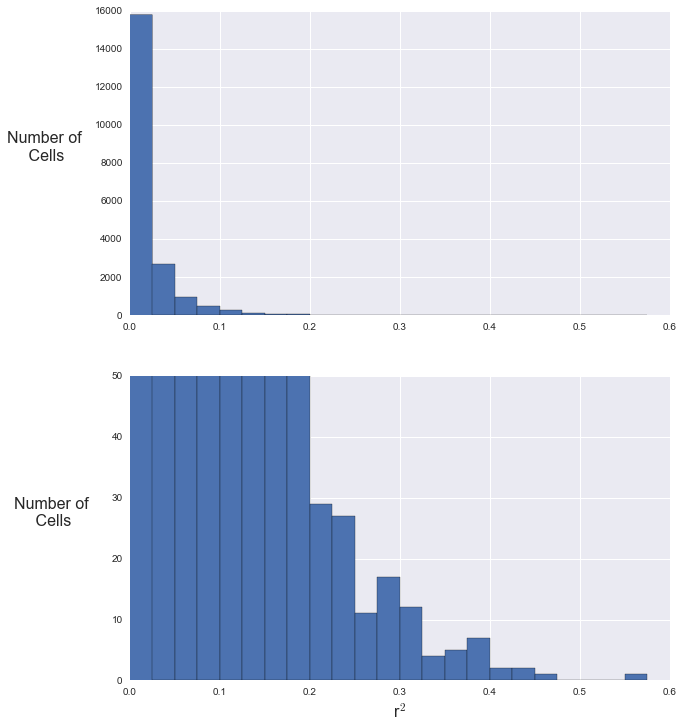

In [219]:
fig,ax = plt.subplots(nrows=2,figsize=(10,12))
fig.subplots_adjust(left=0.20,right=0.95)

binEdges = np.arange(0,0.6,0.025)
ax[0].hist(rmCells_DF.r2_vel.values,bins=binEdges);
ax[1].hist(rmCells_DF.r2_vel.values,bins=binEdges);

ax[0].set_ylabel('Number of\n Cells',rotation=0,fontsize=16)
ax[0].yaxis.labelpad=50
ax[1].set_ylabel('Number of\n Cells',rotation=0,fontsize=16)
ax[1].yaxis.labelpad=60
ax[1].set_ylim(0,50)
ax[1].set_xlabel('r$^2$',fontsize=16)

plt.savefig('/Users/bilalbari/Dropbox/SWDB_BLAZEN_NEURONZZ/finalPresentation/runModulation_correlationHistogram.png')

In [206]:
print np.sum(rmCells_DF.r2_full > 0.2) 
print rmCells_DF.shape[0]
print np.sum(rmCells_DF.r2_acc > 0.25)

experimentID = rmCells_DF[rmCells_DF.r2_full > 0.6].expID
cellNum = rmCells_DF[rmCells_DF.r2_full > 0.6].cellNum
print rmCells_DF.r2_vel[rmCells_DF[rmCells_DF.r2_vel > 0.1].index[0]]

# experimentID = rmCells_DF[rmCells_DF.r2_acc > 0.25].expID
# cellNum = rmCells_DF[rmCells_DF.r2_acc > 0.25].cellNum
# rmCells_DF.head()

# rmCells_DF[rmCells_DF.r2_acc > 0.25].coef_full.values

# experimentID = rmCells_DF[rmCells_DF.r2_vel > 0.1].expID[22]
# cellNum = rmCells_DF[rmCells_DF.r2_vel > 0.1].cellNum[22]
# r2_vel = rmCells_DF[rmCells_DF.r2_vel > 0.1].r2_vel[22]

125
20502
1
0.115274550008


In [186]:
exp = boc.get_ophys_experiment_data(ophys_experiment_id = experimentID)
rVel, t_rVel = exp.get_running_speed()
t_dF, dF = exp.get_dff_traces()

nanMask = ~np.isnan(rVel)
rVel = rVel[nanMask]
rAcc = np.diff(rVel)
dF = dF[:,nanMask]

rVel = rVel[1:]
dF = dF[:,1:]

excessFat_dF = dF.shape[1] % 30 #remove elements that will make it difficult to reshape
if excessFat_dF != 0:
    dF = dF[:,:-excessFat_dF]
dF_resamp = dF.reshape(dF.shape[0],dF.shape[1]/30,30).mean(axis=2)

excessFat_rVel = rVel.shape[0] % 30
if excessFat_rVel != 0:
    rVel = rVel[:-excessFat_rVel]
rVel_resamp = rVel.reshape(rVel.shape[0]/30,30).mean(axis=1)

excessFat_rAcc = rAcc.shape[0] % 30
if excessFat_rAcc != 0:
    rAcc = rAcc[:-excessFat_rAcc]
rAcc_resamp = rAcc.reshape(rAcc.shape[0]/30,30).mean(axis=1)

/Users/bilalbari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 115472 but corresponding boolean dimension is 115473


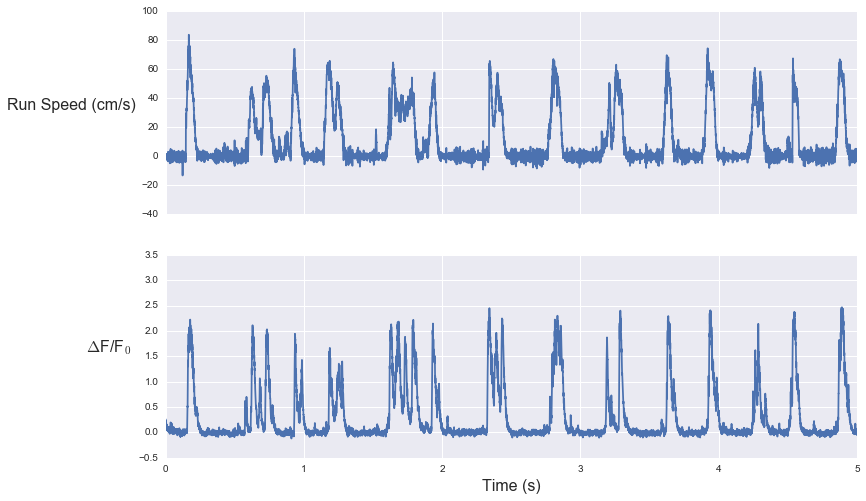

In [187]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(12,8))
ax[0].plot(np.arange(rVel.size)/float(30)/60,rVel)
ax[1].plot(np.arange(rVel.size)/float(30)/60,dF[int(cellNum)])

fig.subplots_adjust(left=0.15,right=0.95)
ax[0].set_xlim(0,5)
ax[0].set_ylabel('Run Speed (cm/s)',fontsize=16,rotation=0)
ax[0].yaxis.labelpad = 70
ax[1].set_ylabel('$\Delta$F/F$_0$',fontsize=16,rotation=0)
ax[1].yaxis.labelpad = 30
ax[1].set_xlabel('Time (s)', fontsize=16)
# ax[1].set_ylim(0,0.2)

# plt.savefig('/Users/bilalbari/Dropbox/SWDB_BLAZEN_NEURONZZ/finalPresentation/runModulation_highCorrelation.png')

In [139]:
# from mpl_toolkits.axes_grid1 import host_subplot
# import mpl_toolkits.axisartist as AA

# fig,ax = plt.subplots(figsize=(12,8))
# host = host_subplot(111, axes_class=AA.Axes)
# plt.subplots_adjust(right=0.75)

# par1 = host.twinx()

# offset = 60
# new_fixed_axis = par1.get_grid_helper().new_fixed_axis
# par1.axis["right"] = new_fixed_axis(loc="right",
#                                     axes=par1,
#                                     offset=(offset, 0))

# par1.axis["right"].toggle(all=True)


# host.set_xlabel("Distance")
# host.set_ylabel("Density")
# par1.set_ylabel("Temperature")

# p1, = host.plot(np.arange(rVel.size)/float(30)/60, rVel, label="Density")
# p2, = par1.plot(np.arange(rVel.size)/float(30)/60, dF[int(cellNum)], label="Temperature")

# host.set_xlim(0, 5)
# host.set_ylim(0, 100)
# par1.set_ylim(0, 6)

# host.legend()

# host.axis["left"].label.set_color(p1.get_color())
# par1.axis["right"].label.set_color(p2.get_color())

# plt.draw()
# plt.show()

(0, 1000)

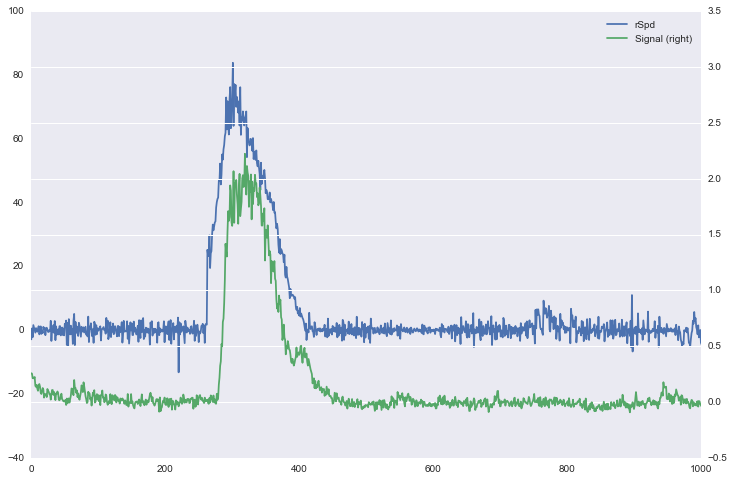